<a href="https://colab.research.google.com/github/donw7/neural_activity_models_DNNs/blob/main/neural-sequence_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# testing transformers on neural activity
- motivation:
  - neuroscience lacks ways of flexibly modeling both global and local modulation of neural activity, lacks accucracy on real-time, and models are computationally inefficient e.g. for BCI applications
  - ML research on sequence models would benefit from extension of transformer architecture into other domains, testing of its embeddings to capture meaningful features of neural activity, such that can be used for behavioral decoding analogous to sentiment analysis, e.g. decoding decision-making akin to sentiment classification 
- framework:
  - neural activity may be construed as a sequence analogous to a text sequence
- applications:
  - interbrain and intrabrain functional connectivity can thus be viewed as machine translation applications
  - brain-behavior relationships as classification



## load dependencies

In [36]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install pytorch_pretrained_bert --quiet

In [37]:
import numpy as np
import pandas as pd
import math
import statistics
from typing import Tuple

import torch
import torch.nn.functional as F
import torchtext
from torch import nn, Tensor
from torch.utils.data import dataset

# transformers library
from transformers import Trainer
from transformers import pipeline
from transformers import set_seed
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM
from transformers import AutoModelForSequenceClassification

# metrics
from datasets import load_metric
from datasets import load_dataset

# interactive dataframe object
from google.colab import data_table
data_table.enable_dataframe_formatter()

# plotly & other tools
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pprint import pprint
import requests, tarfile, os
 

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## set up transformer class and helper functions

In [39]:
class DotProductAttention(nn.Module):
  """Scaled dot product attention."""
  def __init__(self, dropout, **kwargs):
    super(DotProductAttention, self).__init__(**kwargs)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, b, h, t, k):
    """
    Compute dot products. This is the same operation for each head,
    so we can fold the heads into the batch dimension and use torch.bmm
    Note: .contiguous() doesn't change the actual shape of the data,
    but it rearranges the tensor in memory, which will help speed up the computation
    for this batch matrix multiplication.
    .transpose() is used to change the shape of a tensor. It returns a new tensor
    that shares the data with the original tensor. It can only swap two dimension.

    Shape of `queries`: (`batch_size`, no. of queries, head,`k`)
    Shape of `keys`: (`batch_size`, no. of key-value pairs, head, `k`)
    Shape of `values`: (`batch_size`, no. of key-value pairs, head, value dimension)

    b: batch size
    h: number of heads
    t: number of keys/queries/values (for simplicity, let's assume they have the same sizes)
    k: embedding size
    """
    keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
    queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
    values = values.transpose(1, 2).contiguous().view(b * h, t, k)

    # Matrix Multiplication between the keys and queries
    score = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(k)  # size: (b * h, t, t)
    softmax_weights = F.softmax(score, dim=2)  # row-wise normalization of weights

    # Matrix Multiplication between the output of the key and queries multiplication and values.
    out = torch.bmm(self.dropout(softmax_weights), values).view(b, h, t, k)  # rearrange h and t dims
    out = out.transpose(1, 2).contiguous().view(b, t, h * k)

    return out

In [40]:
class TransformerBlock(nn.Module):
  """Transformer Block
  Args:
    k (int): Attention embedding size
    heads (int): number of self-attention heads

  Attributes:
    attention: Multi-head SelfAttention layer
    norm_1, norm_2: LayerNorms
    mlp: feedforward neural network
  """
  def __init__(self, k, heads):
    super().__init__()

    self.attention = SelfAttention(k, heads=heads)

    self.norm_1 = nn.LayerNorm(k)
    self.norm_2 = nn.LayerNorm(k)

    hidden_size = 2 * k  # This is a somewhat arbitrary choice
    self.mlp = nn.Sequential(
        nn.Linear(k, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, k))

  def forward(self, x):
    attended = self.attention(x)
    # Complete the input of the first Add & Normalize layer
    x = self.norm_1(attended + x)
    feedforward = self.mlp(x)
    ## Implement the add & norm in the second block
    # Complete the input of the second Add & Normalize layer
    x = self.norm_2(feedforward + x)

    return x

In [41]:
class SelfAttention(nn.Module):
  """Multi-head self attention layer

  Args:
    k (int): Size of attention embeddings
    heads (int): Number of attention heads

  Attributes:
    to_keys: Transforms input to k x k*heads key vectors
    to_queries: Transforms input to k x k*heads query vectors
    to_values: Transforms input to k x k*heads value vectors
    unify_heads: combines queries, keys and values to a single vector
  """
  def __init__(self, k, heads=8, dropout=0.1):
    super().__init__()
    self.k, self.heads = k, heads

    self.to_keys = nn.Linear(k, k * heads, bias=False)
    self.to_queries = nn.Linear(k, k * heads, bias=False)
    self.to_values = nn.Linear(k, k * heads, bias=False)
    self.unify_heads = nn.Linear(k * heads, k)

    self.attention = DotProductAttention(dropout)

  def forward(self, x):
    """Implements forward pass of self-attention layer
    Args:
      x (torch.Tensor): batch x t x k sized input
    """
    b, t, k = x.size()
    h = self.heads

    # reshape the queries, keys and values so that each head has its own dimension
    queries = self.to_queries(x).view(b, t, h, k)
    keys = self.to_keys(x).view(b, t, h, k)
    values = self.to_values(x).view(b, t, h, k)

    out = self.attention(queries, keys, values, b, h, t, k)

    return self.unify_heads(out)

In [42]:
class TransformerSentiment(nn.Module):
  """Transformer Encoder network for classification

    Args:
      k (int): Attention embedding size
      heads (int): Number of self attention heads
      depth (int): How many transformer blocks to include
      seq_length (int): How long an input sequence is
      num_tokens (int): Size of dictionary
      num_classes (int): Number of output classes
  """
  def __init__(self, k, heads, depth, seq_length, num_tokens, num_classes):
    super().__init__()

    self.k = k
    self.num_tokens = num_tokens
    self.token_embedding = nn.Embedding(num_tokens, k)
    self.pos_enc = PositionalEncoding(k)

    transformer_blocks = []
    for i in range(depth):
      transformer_blocks.append(TransformerBlock(k=k, heads=heads))

    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.classification_head = nn.Linear(k, num_classes)

  def forward(self, x):
    """Forward pass for Classification Transformer network

    Args:
      x (torch.Tensor): (b, t) sized tensor of tokenized words

    Returns:
      torch.Tensor of size (b, c) with log-probabilities over classes
    """
    x = self.token_embedding(x) * np.sqrt(self.k)
    x = self.pos_enc(x)
    x = self.transformer_blocks(x)

    # mean pooling
    sequence_avg = x.mean(dim=1)
    x = self.classification_head(sequence_avg)
    logprobs = F.log_softmax(x, dim=1)

    return logprobs

In [43]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


### train function

In [44]:
def train(model, loss_fn, train_loader,
          n_iter=1, learning_rate=1e-4,
          test_loader=None, device='cpu',
          L2_penalty=0, L1_penalty=0):
  """Run gradient descent to opimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data
    n_iter (int, optional): number of iterations of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent
    test_data (torch.Tensor, optional): n_test x n_neurons tensor with neural
      responses to test on
    test_labels (torch.Tensor, optional): n_test x 1 tensor with orientations of
      the stimuli corresponding to each row of test_data
    L2_penalty (float, optional): l2 penalty regularizer coefficient
    L1_penalty (float, optional): l1 penalty regularizer coefficient

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch Adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []
  test_loss = []

  # Loop over epochs (cf. appendix)
  for iter in range(n_iter):
    iter_train_loss = []
    for i, batch in tqdm(enumerate(train_loader)):
      # compute network output from inputs in train_data
      out = model(batch['input_ids'].to(device))
      loss = loss_fn(out, batch['label'].to(device))

      # Clear previous gradients
      optimizer.zero_grad()

      # Compute gradients
      loss.backward()

      # Update weights
      optimizer.step()

      # Store current value of loss
      iter_train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar
      if i % 50 == 0:
        print(f'[Batch {i}]: train_loss: {loss.item()}')
    train_loss.append(statistics.mean(iter_train_loss))

    # Track progress
    if True: #(iter + 1) % (n_iter // 5) == 0:

      if test_loader is not None:
        print('Running Test loop')
        iter_loss_test = []
        for j, test_batch in enumerate(test_loader):

          out_test = model(test_batch['input_ids'].to(device))
          loss_test = loss_fn(out_test, test_batch['label'].to(device))
          iter_loss_test.append(loss_test.item())

        test_loss.append(statistics.mean(iter_loss_test))

      if test_loader is None:
        print(f'iteration {iter + 1}/{n_iter} | train loss: {loss.item():.3f}')
      else:
        print(f'iteration {iter + 1}/{n_iter} | train loss: {loss.item():.3f} | test_loss: {loss_test.item():.3f}')

  if test_loader is None:
    return train_loss
  else:
    return train_loss, test_loss



### load data function

In [45]:
def load_yelp_data(DS, tokenizer):
  dataset = DS
  dataset['train'] = dataset['train'].select(range(10000)) # hardcoded selection
  dataset['test'] = dataset['test'].select(range(5000))
  dataset = dataset.map(lambda e: tokenizer(e['text'], truncation=True,
                                            padding='max_length'), batched=True) # tokenize
  dataset.set_format(type='torch', columns=['input_ids', 'label']) # set format

  train_loader = torch.utils.data.DataLoader(dataset['train'], batch_size=32) # hardcoded batch size
  test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=32)

  vocab_size = tokenizer.vocab_size
  max_len = next(iter(train_loader))['input_ids'].shape[0]
  num_classes = next(iter(train_loader))['label'].shape[0]

  return train_loader, test_loader, max_len, vocab_size, num_classes
  

## load neural activity dataset

from Steinmetz et al., 2019, session "Cori_2016-12-18". See explanation below

In [46]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1W3TwEtC0Z6Qmbfuz8_AWRiQHfuDb9FIS',
                                    dest_path='./Binned_data.zip',
                                    unzip=True)

binned_spikes = np.load('binned_spikes.npy')
choices = np.load('choices.npy')+1


In [47]:
# 228 trials, 1089 neurons, and 50 bins per trial (for a time of 20ms per bin).
print(binned_spikes.shape, choices.shape)
print(binned_spikes.dtype, choices.dtype)

(228, 1089, 50) (228,)
float64 float64


In [48]:
print(binned_spikes[1,:,:])
print(choices[:10])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
[2. 2. 0. 0. 0. 1. 0. 0. 0. 2.]


In [49]:
# plt.eventplot(binned_spikes[1,:,:].T)

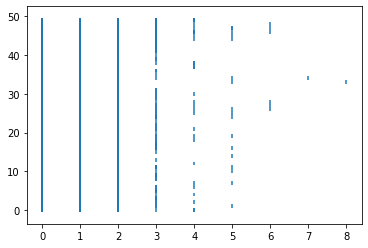

## load text dataset

In [50]:
DS = load_dataset("yelp_review_full", download_mode="reuse_dataset_if_exists")
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
train_loader, test_loader, max_len, vocab_size, num_classes = load_yelp_data(DS, tokenizer)
batch1 = next(iter(test_loader))

Reusing dataset yelp_review_full (/root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/13c31a618ba62568ec8572a222a283dfc29a6517776a3ac5945fb508877dde43)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/13c31a618ba62568ec8572a222a283dfc29a6517776a3ac5945fb508877dde43/cache-a64c06a39f1a070a.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/13c31a618ba62568ec8572a222a283dfc29a6517776a3ac5945fb508877dde43/cache-eeb868e94a6d8874.arrow


## data exploration

### neural data

Neuropixels recordings from Steinmetz et al., 2019 of mice engaging in visual decision-making task. Will try to predict choices from 1 s of neural activity prior to choice. 

"Mice earned water rewards by turning a wheel to indicate which of two visual gratings had higher contrast, or by not turning if no stimulus was presented. When stimuli had equal contrast, a left or right choice was rewarded with 50% probability."

Paradigm: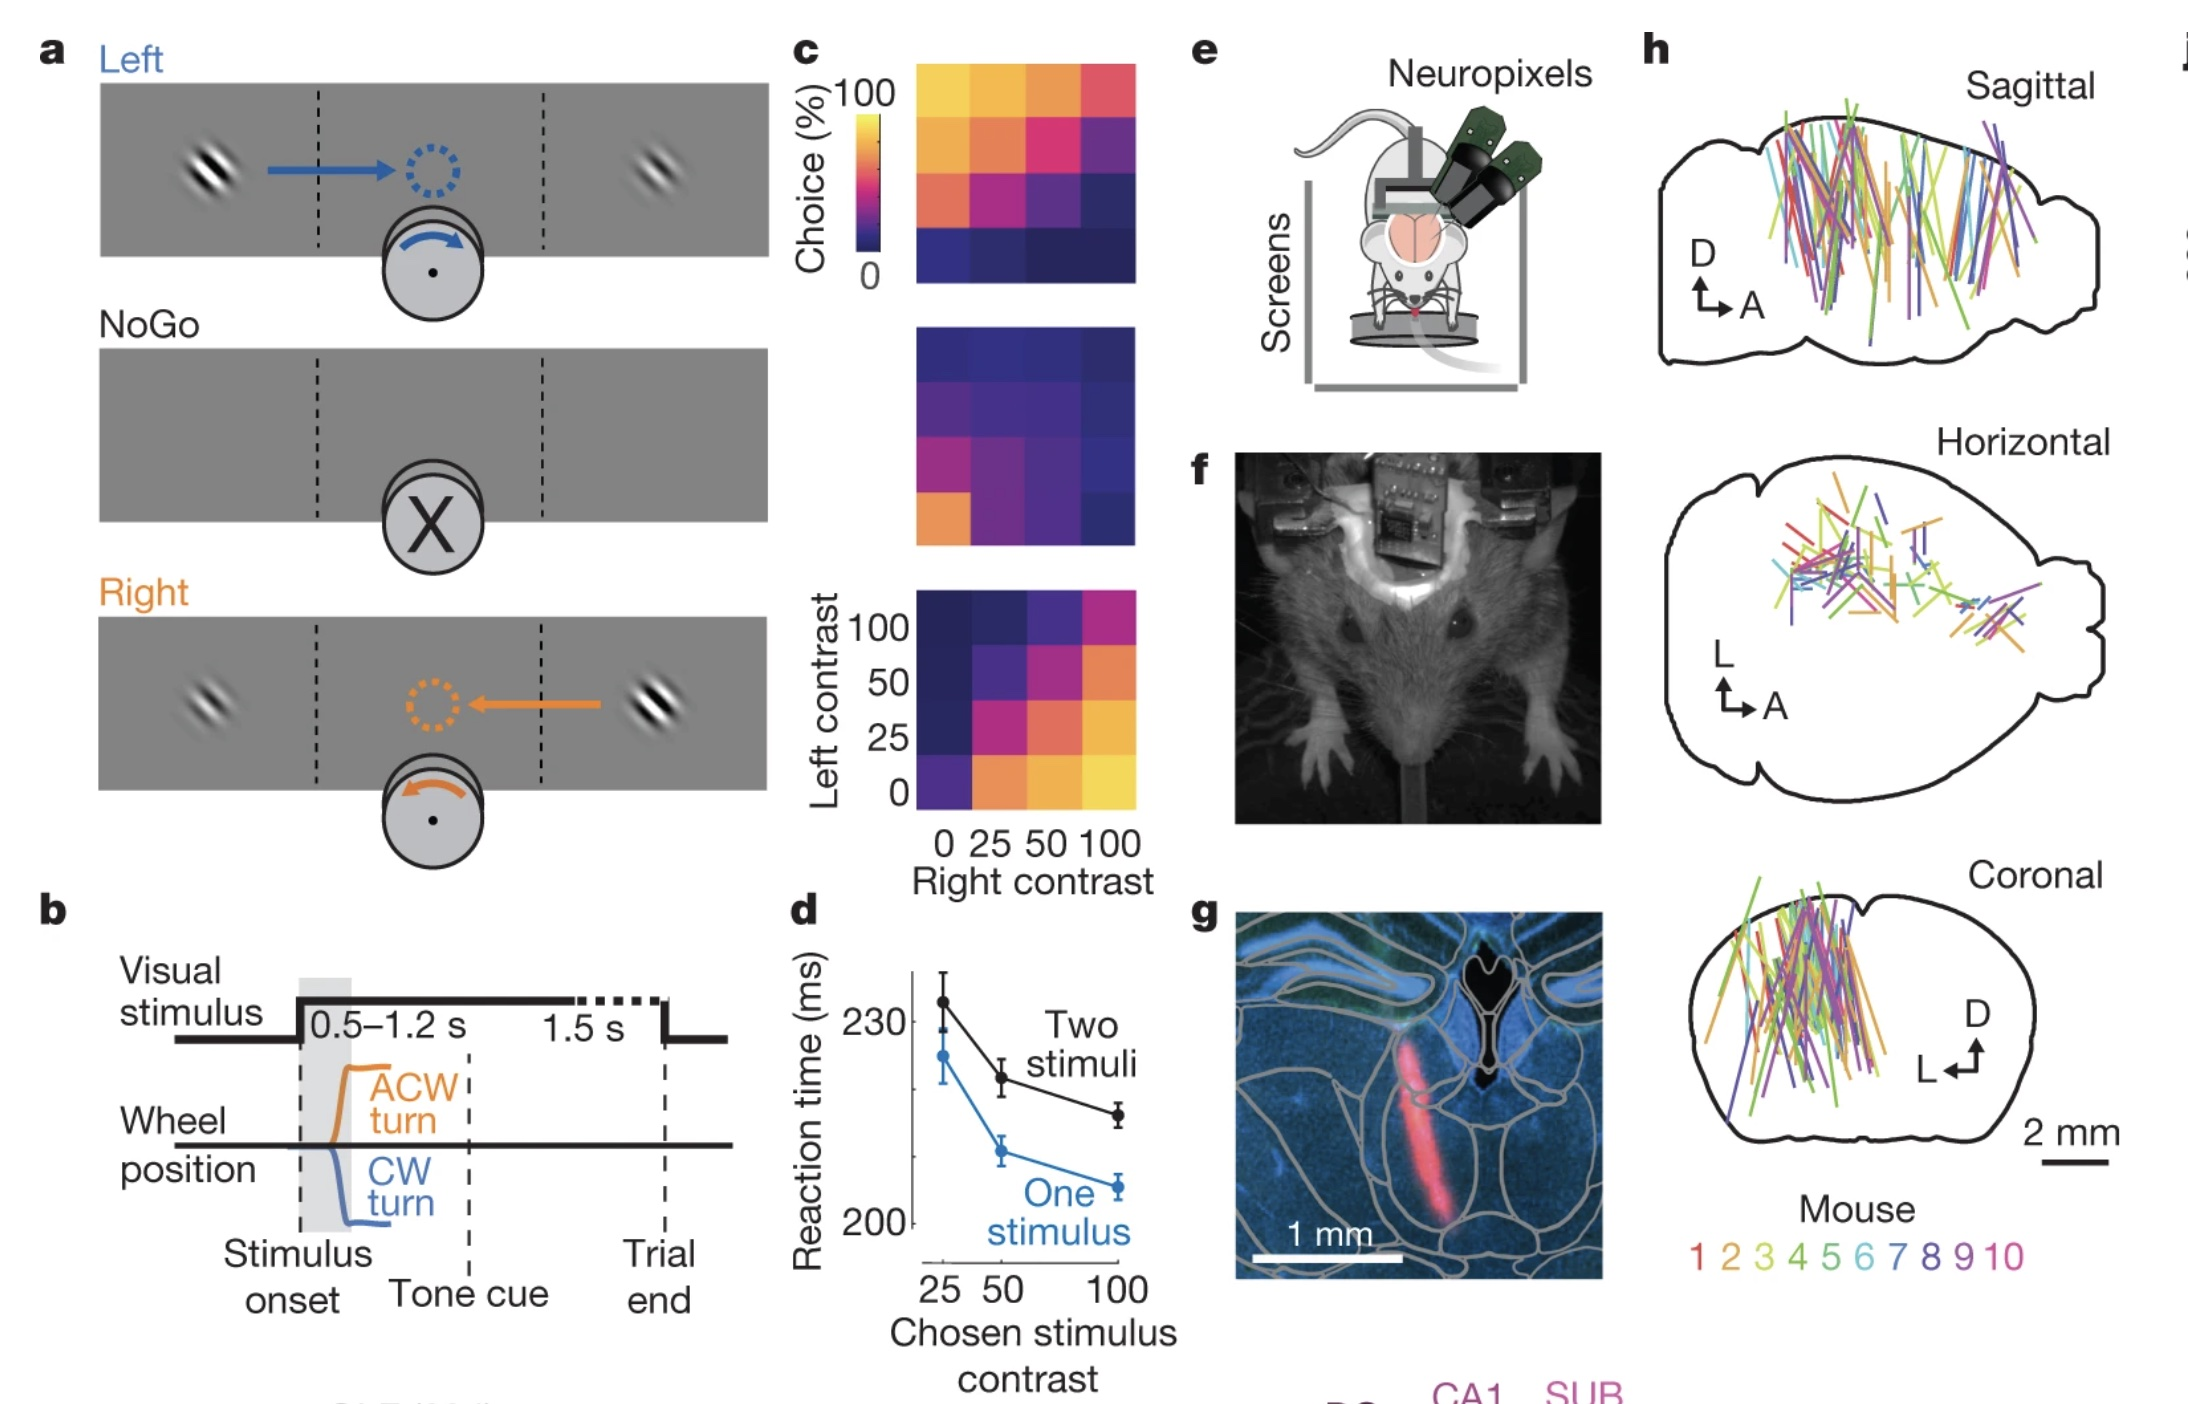

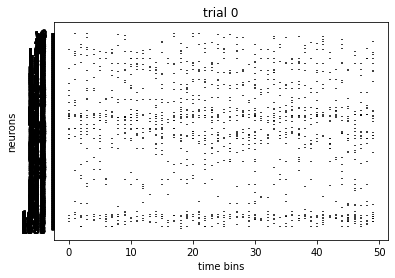

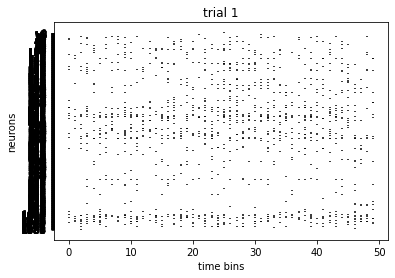

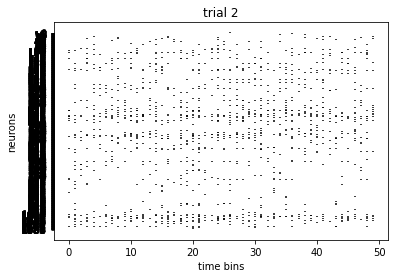

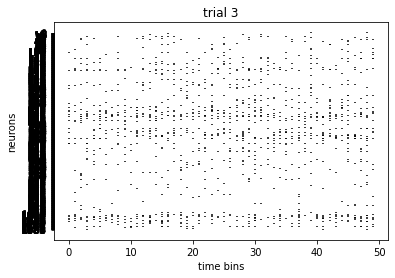

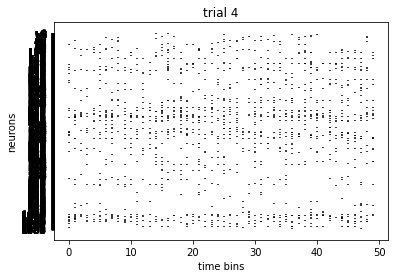

In [51]:
# print binned spikes event plots
displayidx = range(5) # trial indices to display
for di in displayidx:
  df_spikes_trial = pd.DataFrame(binned_spikes[di,:,:].T)
  positions = df_spikes_trial.apply(lambda x: df_spikes_trial.index[x == 1])
  plt.figure(di)
  plt.eventplot(positions, linelengths=2, lineoffsets=1, colors='black')
  plt.yticks(range(positions.index.size), positions.index)
  plt.gca().invert_yaxis()
  plt.ylabel('neurons')
  plt.xlabel('time bins')
  plt.title(f'trial {di}')

In [52]:
# print choices
for di in displayidx:
  print(f"decision, trial {di}: {choices[di]}")

decision, trial 0: 2.0
decision, trial 1: 2.0
decision, trial 2: 0.0
decision, trial 3: 0.0
decision, trial 4: 0.0


trial 4
450                        Int64Index([], dtype='int64')
451    Int64Index([0, 4, 5, 7, 28, 30, 32, 35, 36, 39...
452             Int64Index([1, 2, 6, 40], dtype='int64')
453    Int64Index([4, 7, 9, 17, 18, 20, 26, 27, 29, 3...
454    Int64Index([0, 5, 6, 7, 27, 29, 32, 39, 40, 41...
dtype: object


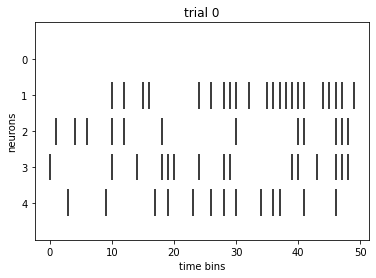

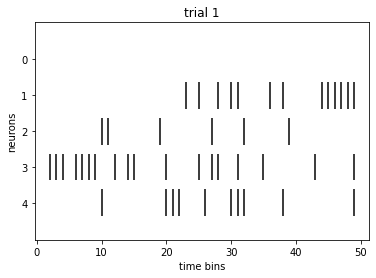

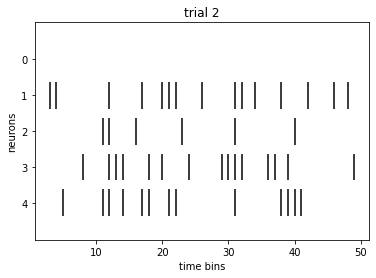

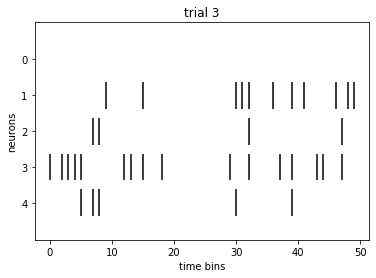

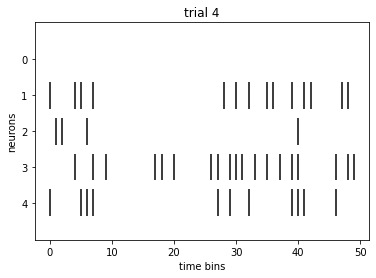

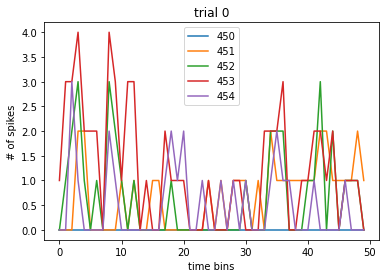

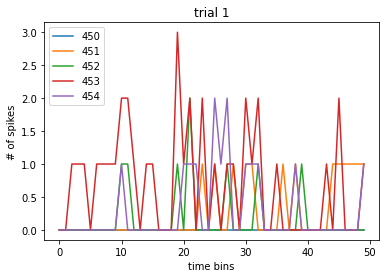

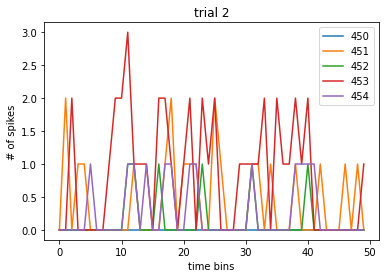

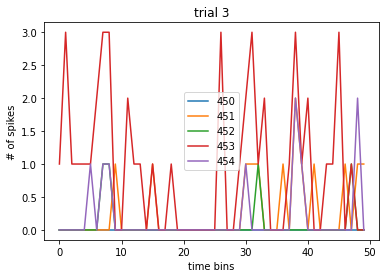

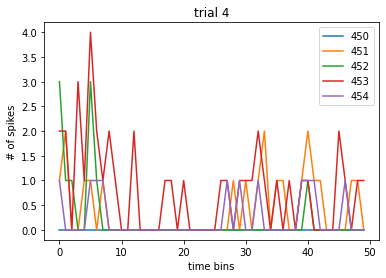

In [53]:
# sanity check
neudisplayidx = range(450, 455) # number of neurons to display

# check positions
print(f'trial {di}')
print(positions[450:455])

# print binned spikes event plots
displayidx = range(5) # trial indices to display
for di in displayidx:
  df_spikes_trial = pd.DataFrame(binned_spikes[di,neudisplayidx,:].T)
  positions = df_spikes_trial.apply(lambda x: df_spikes_trial.index[x == 1])
  plt.figure(di)
  plt.eventplot(positions, linelengths=0.75, colors='black')
  plt.yticks(range(positions.index.size), positions.index)
  plt.gca().invert_yaxis()
  plt.ylabel('neurons')
  plt.xlabel('time bins')
  plt.title(f'trial {di}')

# display neurons with another plot type
for di in displayidx: # trials
  plt.figure()
  plt.ylabel('# of spikes')
  plt.xlabel('time bins')
  plt.title(f'trial {di}')
  for ni in neudisplayidx: # neurons
    neuron = binned_spikes[di,ni,:] # all trial, 1 neurons, all time bins
    plt.plot(neuron)
  plt.legend(neudisplayidx)

Text(0.5, 1.0, 'Log bins')

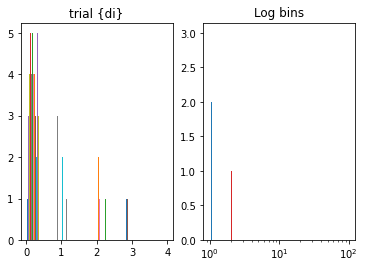

In [54]:
# histogram (last trial displayed)
fig, ax = plt.subplots(1,2)
ax[0].hist(df_spikes_trial)
ax[0].set_title('trial {di}')

ax[1].hist(df_spikes_trial, bins=np.logspace(0,2))
ax[1].set_xscale('log')
ax[1].set_title('Log bins')


Example heat map for firing rate:




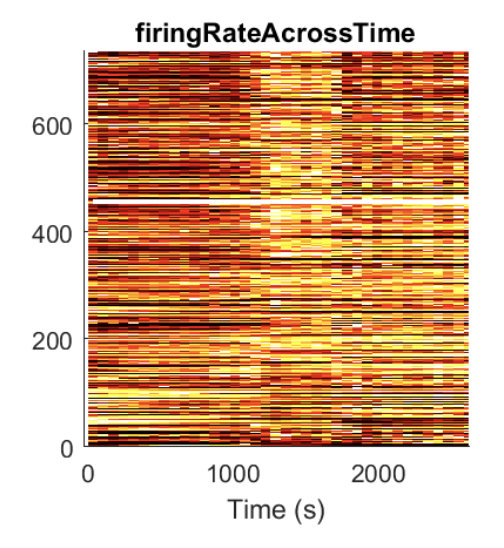

[[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
  1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
  3.96767474e-01 5.38816734e-01 4.19194514e-01 6.85219500e-01
  2.04452250e-01 8.78117436e-01 2.73875932e-02 6.70467510e-01
  4.17304802e-01 5.58689828e-01 1.40386939e-01 1.98101489e-01
  8.00744569e-01 9.68261576e-01 3.13424178e-01 6.92322616e-01
  8.76389152e-01 8.94606664e-01 8.50442114e-02 3.90547832e-02
  1.69830420e-01 8.78142503e-01 9.83468338e-02 4.21107625e-01
  9.57889530e-01 5.33165285e-01 6.91877114e-01 3.15515631e-01
  6.86500928e-01 8.34625672e-01 1.82882773e-02 7.50144315e-01
  9.88861089e-01 7.48165654e-01 2.80443992e-01 7.89279328e-01
  1.03226007e-01 4.47893526e-01 9.08595503e-01 2.93614148e-01
  2.87775339e-01 1.30028572e-01]
 [1.93669579e-02 6.78835533e-01 2.11628116e-01 2.65546659e-01
  4.91573159e-01 5.33625451e-02 5.74117605e-01 1.46728575e-01
  5.89305537e-01 6.99758360e-01 1.02334429e-01 4.14055988e-01
  6.94400158e-01 4.14179270e-01 4.995

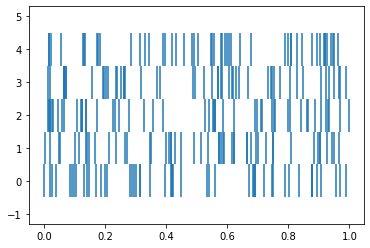

In [55]:
data1 = np.random.random([5, 50])
print(data1)
plt.eventplot(data1)

### text data

In [ ]:
print(DS.column_names)
print(DS.shape)
print(f"text is {type(train_loader.dataset['text'])}")
print(f"label is {type(train_loader.dataset['label'])}")

df_text = pd.DataFrame(train_loader.dataset['text'])
df_label = pd.DataFrame(train_loader.dataset['label'])
df_labeltext = pd.concat([df_label, df_text], axis=1)

# choices as first column, spikes as rest
display(df_labeltext)

## test train on text data

In [ ]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize network with embedding size 128, 8 attention heads, and 3 layers
model = TransformerSentiment(128, 8, 3, max_len, vocab_size, num_classes).to(device)

# Initialize built-in PyTorch Negative Log Likelihood loss function
loss_fn = F.nll_loss

train_loss, test_loss = train(model,
                              loss_fn,
                              train_loader,
                              n_iter = 3,
                              test_loader=test_loader,
                              device=device)

In [58]:
print(pd.concat([pd.DataFrame(train_loss), pd.DataFrame(test_loss)], axis=1))

          0         0
0  1.713617  1.530819
1  1.535325  1.448654
2  1.403885  1.313075


### interactive plot of training loss

In [59]:
# plotly interactive plots not displayed properly on github preview
fig = go.Figure()
fig.add_trace(go.Scatter(y=train_loss,
                    mode='lines',
                    name='train_loss'))
fig.add_trace(go.Scatter(y=test_loss,
                    mode='lines',
                    name='test_loss'))
fig.update_layout(title='Training loss',
                   xaxis_title='epoch',
                   yaxis_title='loss')

fig.show()

### test predictions

In [60]:
# set idx up to batch size (e.g. 32)
# from dataset
idx = 20
pred_text = DS['test']['text'][idx]
actual_label = DS['test']['label'][idx]
print(pred_text)
print(actual_label)

The evites are in the mail for the 2 for $99 special! You will have to spend $24 on a parking pass. I signed up last year for this promotion and don't think I got the passes worth. \n\nThe waterpark is nice and lounging by the pool or floating around the lazy river is perfect for a hot summer day. There are just too many misses in my book though.\n\n1st off all Traffic is a biatch! Be ready to sit on browns hill rd for a very long time unless you leave before 9am and wait for the park to open at 10am. \n\nNext remember it is a family park so there will be lots of rude and bratty kids all over the place. (I'm not a mean kid hater) my experiences have been bad at the Sandbar pool. \n\nIf you do arrive early enough you will be standing in the hot sun with a gang of kids that WILL push you out of the way and run to claim 10 chairs with towels even though they won't use them because they run around the park all day. I actually got into an argument last summer with one said kid. I was like \

In [61]:
# predict with trained model
with torch.no_grad():
  # Batch 1 contains all the tokenized text for the 1st batch of the test loader
  pred_batch = model(batch1['input_ids'].to(device))
  # Predicting the label for the text
  print("The yelp review is → " + str(pred_text))
  predicted_label = np.argmax(pred_batch[idx].cpu())
  print()
  print("The Predicted Rating is → " + str(predicted_label) + " and the Actual Rating was → " + str(actual_label))

The yelp review is → The evites are in the mail for the 2 for $99 special! You will have to spend $24 on a parking pass. I signed up last year for this promotion and don't think I got the passes worth. \n\nThe waterpark is nice and lounging by the pool or floating around the lazy river is perfect for a hot summer day. There are just too many misses in my book though.\n\n1st off all Traffic is a biatch! Be ready to sit on browns hill rd for a very long time unless you leave before 9am and wait for the park to open at 10am. \n\nNext remember it is a family park so there will be lots of rude and bratty kids all over the place. (I'm not a mean kid hater) my experiences have been bad at the Sandbar pool. \n\nIf you do arrive early enough you will be standing in the hot sun with a gang of kids that WILL push you out of the way and run to claim 10 chairs with towels even though they won't use them because they run around the park all day. I actually got into an argument last summer with one s

## test load & train on neural activity data

potential issues to consider:
- tokenization & vectorization?
- embedding needed?
- can spikes be represented simply as a "dictionary" of e.g. 1-5 conditional probabilities?

### modify transformer functions

In [71]:
class TransformerNeural(nn.Module):
  """Transformer Encoder network for classification

    Args:
      k (int): Attention embedding size
      heads (int): Number of self attention heads
      depth (int): How many transformer blocks to include
      seq_length (int): How long an input sequence is
      num_tokens (int): Size of dictionary
      num_classes (int): Number of output classes
  """
  def __init__(self, k, heads, depth, seq_length, num_tokens, num_classes):
    super().__init__()

    self.k = k
    self.num_tokens = num_tokens
    #self.token_embedding = nn.Embedding(num_tokens, k)
    #self.pos_enc = PositionalEncoding(k)

    transformer_blocks = []
    for i in range(depth):
      transformer_blocks.append(TransformerBlock(k=k, heads=heads))

    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.classification_head = nn.Linear(k, num_classes)

  def forward(self, x):
    """Forward pass for Classification Transformer network

    Args:
      x (torch.Tensor): (b, t) sized tensor of tokenized words

    Returns:
      torch.Tensor of size (b, c) with log-probabilities over classes
    """
    #x = self.token_embedding(x) * np.sqrt(self.k)
    #x = self.pos_enc(x)
    x = self.transformer_blocks(x)

    # mean pooling
    sequence_avg = x.mean(dim=1)
    x = self.classification_head(sequence_avg)
    logprobs = F.log_softmax(x, dim=1)

    return logprobs

In [68]:
def load_neural_data(nDS): #, tokenizer):
  # nDS['train'] = nDS['train'].select(range(10000)) # hardcoded selection
  # nDS['train'] = nDS['train'].select(range(200)) # hardcoded selection
  # nDS['test'] = nDS['test'].select(range(5000))
  # nDS['test'] = nDS['test'].select(range(200, 228))

  # nDS = nDS.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length'), batched=True) # tokenize
  nDS.set_format(type='torch', columns=['input_ids', 'label']) # set format

  train_loader = torch.utils.data.DataLoader(nDS['train'], batch_size=32) # hardcoded batch size
  test_loader = torch.utils.data.DataLoader(nDS['test'], batch_size=32)

  # vocab_size = tokenizer.vocab_size
  max_len = next(iter(train_loader))['input_ids'].shape[0]
  num_classes = next(iter(train_loader))['label'].shape[0]

  return train_loader, test_loader, max_len, num_classes #, vocab_size
  

### reformat neural data

In [78]:
# ?load_dataset # from hugging face?
# ?train_loader # from utils

In [64]:
print(DS.column_names)
print(DS.shape)
print(f"text is {type(train_loader.dataset['text'])}")
print(f"label is {type(train_loader.dataset['label'])}")
text = train_loader.dataset['text']
label = train_loader.dataset['label']
print(text[0])
print(label[0])

{'train': ['label', 'text'], 'test': ['label', 'text']}
{'train': (10000, 2), 'test': (5000, 2)}
text is <class 'list'>
label is <class 'torch.Tensor'>
dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.
tensor(4)


In [ ]:
df_text # = pd.DataFrame(train_loader.dataset['text'])
df_label # = pd.DataFrame(train_loader.dataset['label'])
df_labeltext # = pd.concat([df_label, df_text], axis=1)

In [ ]:
print(np.unique(choices))
pd.DataFrame(choices).describe()

In [ ]:
df_label.describe()

In [69]:
# DS has 'train' and 'test' splits
DS = load_dataset("yelp_review_full", download_mode="reuse_dataset_if_exists")

# tools
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# load
train_loader, test_loader, max_len, vocab_size, num_classes = load_yelp_data(DS, tokenizer)

# iterate
batch1 = next(iter(test_loader))

Reusing dataset yelp_review_full (/root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/13c31a618ba62568ec8572a222a283dfc29a6517776a3ac5945fb508877dde43)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/13c31a618ba62568ec8572a222a283dfc29a6517776a3ac5945fb508877dde43/cache-a64c06a39f1a070a.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/13c31a618ba62568ec8572a222a283dfc29a6517776a3ac5945fb508877dde43/cache-eeb868e94a6d8874.arrow


In [93]:
nDS = DS;
print(nDS)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 5000
    })
})


In [77]:
batch1_text = next(iter(train_loader))
print(batch1_text['input_ids'])
print(batch1_text['input_ids'].shape)

tensor([[  101,   173,  1197,  ...,     0,     0,     0],
        [  101,  7595,   117,  ...,     0,     0,     0],
        [  101, 18511,  1280,  ...,     0,     0,     0],
        ...,
        [  101,   146,  1762,  ...,     0,     0,     0],
        [  101, 18098,  1576,  ...,     0,     0,     0],
        [  101,  1960, 13077,  ...,   146,  1309,   102]])
torch.Size([32, 512])
